<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/ch1_2_Deep_Implicit_Layer_Fixedpoint_using_Anderson_Acceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving for Fixed Point Layer using Implicit Differentiation

- Reference https://implicit-layers-tutorial.org/introduction/
- section: **Differentiation in Implicit Layers**

Note:
- function g can be used to represent convolutions, self-attention, or any other feature

# Key Points
1. Solve for the root of the implicit layer g(x, z*) = 0, outisde of the automatic diferentiation tape
2. Use the automatic differentiation tape to run the following assignment within the differentiation tape:
    z:=z⋆−g(x,z⋆)
  - this is like reinserting the partial dervatives −∂g/∂x to the autograd tape
3. Add a backward hook to the backward pass that multiplies by (∂g/∂z⋆).transpose
  - this will fix the backward pass so that it correctly implements the gradient according to the implicit function theorem

Reference: anderson Acceleration Wikipedia link https://en.wikipedia.org/wiki/Anderson_acceleration

In [2]:
import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class TanhNewtonImplicitLayer(nn.Module):
  def __init__(self, out_features, tol=1e-8, max_iter=100):
    super().__init__()
    self.linear = nn.Linear(out_features, out_features, bias=False) # (C, C)
    self.tol = tol
    self.max_iter = max_iter

  def forward(self, x):
    # Run Newton's method outside of the autograd framework
    with torch.no_grad():
      z = torch.tanh(x) # (B, C) | Initial guess, z0 = tanh(x)
      # print(f'0. Start with :{z.shape=}')
      self.iterations = 0
      while self.iterations < self.max_iter: # by iteratively doing it cond: iterations < max_iter or (z - tanh(z_linear) < self.tol | objective is to find J = (∂g/∂z⋆)
        z_linear = self.linear(z) + x # (B, C)
        g = z - torch.tanh(z_linear) # (B, C)
        self.err = torch.norm(g) # L2 norm | euclidean distance
        if self.err < self.tol:
          break

        # newton Root Finding Method: 1. compute the gradient
        # Jacobian = (∂g/∂z⋆), where
        # g(x,z)= z − tanh(Wz+x), hence
        # J = I - diag(tanh'(Wz* + x)) * W, where
        # Identity matrix = I
        # Adjustment term = ∂(tanh(Wz*+x))/∂z = diag(tanh'(Wz* + x)) * W
        identity_matrix = torch.diag(torch.ones(g.shape[1], device=z.device))         # (C, C) | square identity matriX
        identity_matrix = identity_matrix.unsqueeze(0)               # (1, C, C) | add a batch dimension to I for broadcasting
        adjustment_term_1 = (1/ torch.cosh(z_linear)**2).unsqueeze(2) # (B, C, 1) | add 1 dim for channels
        adjustment_term_2 = (self.linear.weight).unsqueeze(0)          # (1, C, C) | add 1 dim for C
        adjustment_term = adjustment_term_1 * adjustment_term_2      # (B, C, C)
        J = identity_matrix - adjustment_term # (B, C, C) | (∂g/∂z⋆)

        # Newton Root finding method: 2. newton step update
        # compute delta_z
        z = z - torch.linalg.solve(J, g.unsqueeze(2)).squeeze(2) # (B, C) | z-new = z − (∂g/∂z⋆)**−1 * g(z)
        # print(f'{self.err=}')
        self.iterations += 1


    # renengage autograd and add the gradient hook
    z = torch.tanh(self.linear(z) + x) # Recompute z to include it in the autograd computation graph

    # jacobian_transpose = J.transpose(1, 2)
    # Solving the linear system 𝐽.𝑇ranspose * 𝛿 = grad, where 𝐽.𝑇ranspose is the transposed Jacobian and grad is the incoming gradient.
    # call register_hook on a tensor, you are effectively saying,
    # Whenever a gradient is computed for this tensor during backpropagation, apply this function to the gradient before proceeding.
    # grad in register_hook is the gradient of the loss wrt to the tensor z. It is computed during the backward pass.
    # Specifically, it is the derivative of the loss function with respect to z, which is propagated from the loss through the layers of the network back to z.
    z.register_hook(lambda grad: torch.linalg.solve(J.transpose(1, 2), grad.unsqueeze(2)).squeeze(2))
    # print(f'10 {J[0]=} | {z.grad=} \n')
    return z


#Summing Up: Forward Pass
- Objective: Find Jacobian matrix (∂g/∂z⋆)
- Step 1: start with an initiat guess for z = tanh(x)
- Next Steps to be executed iteratively
  - Step 2:
    - 'self.linear(z) + x': Applies a linear transformation to z and adds x.
    - 'torch.tanh(...)': Applies the hyperbolic tangent activation function.
  - Step 3: Calculate the jacobian matrix (gradient of function g(x, z*) wrt to
   intermediate output z*
   - J = I - tanh'(WZ* + X)
   - Some Notes about the Jacobian calculation:
    - g(z*, x) is of size (B, C), i.e. each batch sample is a vector of dimension/channels/features = C
    - First we calculate the element-wise derivative of each element in each batch, i.e. the derivative of an element in a batch sample wrt to other elements will be zero
    - this will result in a final jacobian of size (B, C, C) which will be block-diagonal
    - The terms computed in order to compute the final jacobian matrix, include
      - Identity matrix is of size (C, C)
      - sehc(z)^2 = (1/cosh(z)^2) | this will be size (B, C) since we are calculating element-wise derivative
      - next, multiple the sec^2 derivative term with the weights of the linear layer W which is of size (C, C)
      - in order to broadcast derivative (sech^2) for each element to be multiplied with each respective element of linear layer weights, we do the following transformation
      - sech^2 [:, :, None] | W [None, :, :] | i.e. add one spurious dimension to convert (B, C) -> (B, C, 1) | add one spurious dimension to convert (C, C) -> (1, C, C)
      - resulting in a jacobian matrix of size (B, C, C) which stores the final gradients of each element in channel-dimention for each vector in batch (batch sample)


# Summing up: Backward Pass
- Once the gradients (Jacobian Matrix) = (∂g/∂z⋆) is computed
- we recompute z = tanh(Wz + x) | creates the computational graph
- register a grad hook to z which will propagate the gradients in the backward pass


In [9]:
from torch.autograd import gradcheck

# simple Setup
# layer = TanhNewtonImplicitLayer(50, tol=1e-10).double()
# print('no. of params in the layer: ', {sum(p.nelement() for p in layer.parameters())})
# X = torch.randn((30, 50)).double()

# mode complex input
N = 100  # Number of samples / Batches
D = 50   # Number of dimensions / Features

X = torch.tensor(np.linspace(-15, 20, N)).reshape(-1, 1).repeat(1, D).float()
X += torch.tensor(np.sin(np.linspace(0, 2*np.pi, N))).reshape(-1, 1).repeat(1, D).float()
X += torch.randn(N, D) * 0.1  # Adding some noise
X /= torch.sqrt(torch.tensor(N)) # scaling input tensor with sqrt of fan_in [kaiming normalizaiton], in order to not saturate the tanh output

# Create layer
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
  layer = TanhNewtonImplicitLayer(out_features = D)
  Z = layer(X)
  prof.step()

# Print profiling results
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

print(f'Terminated after {layer.iterations} iterations with error {layer.err}')

------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::_linalg_solve_ex         0.87%       2.910ms        82.52%     274.471ms       2.745ms      99.22 Mb      99.22 Mb           100  
                     aten::sub         4.85%      16.138ms         4.85%      16.138ms      53.793us      99.18 Mb      99.18 Mb           300  
                     aten::mul         4.11%      13.671ms         4.48%      14.915ms      74.575us      97.27 Mb      97.27 Mb           200  
                    aten::tanh         0.30%     989.000us         0.30%     989.000us       9.696us       1.95 Mb       1.95 Mb  

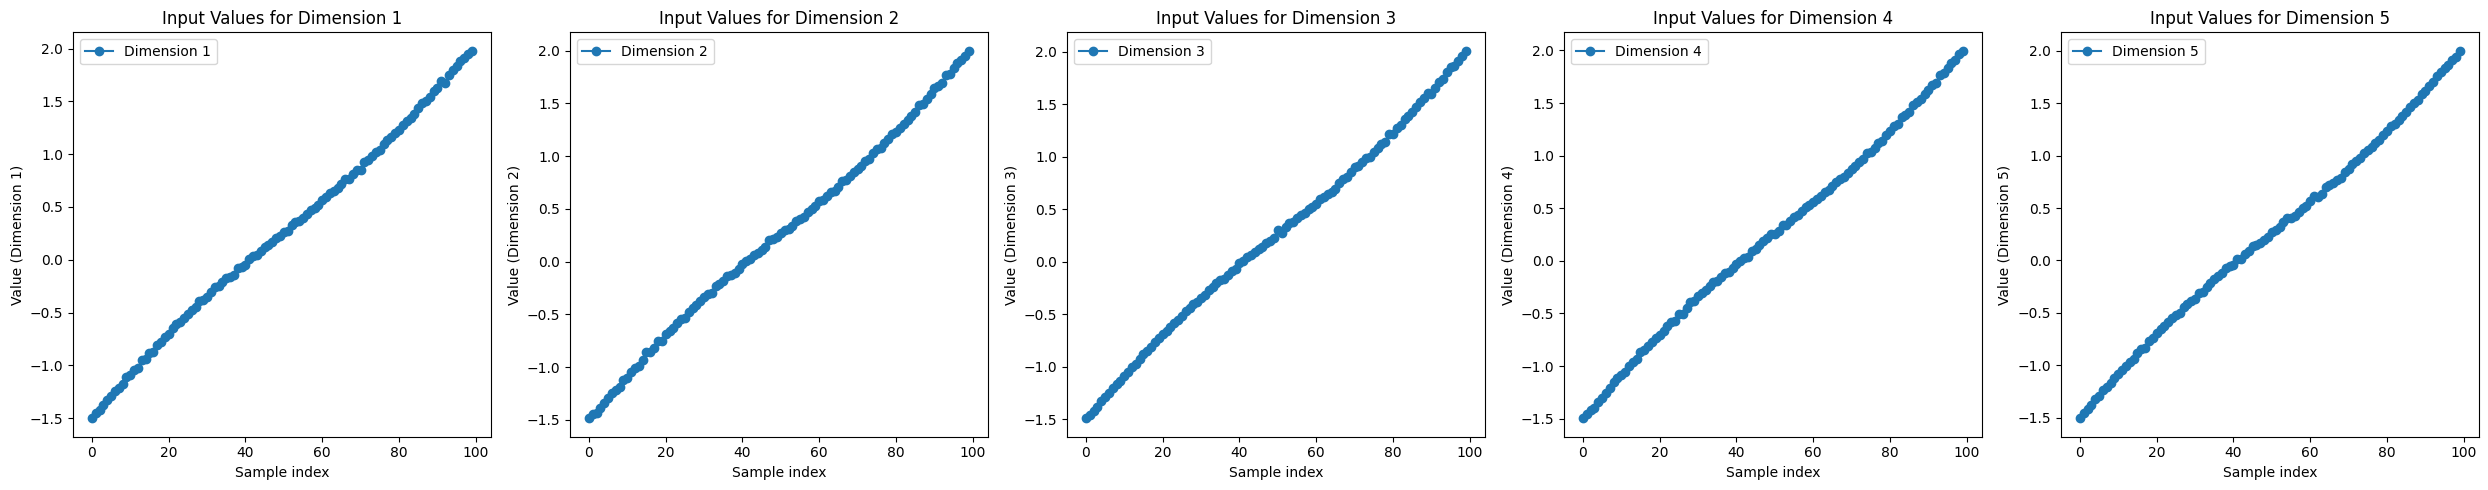

In [10]:
# Plotting the input tensor X for a few dimensions
plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(range(N), X[:, i].detach().numpy(), 'o-', label=f'Dimension {i+1}')
    plt.xlabel('Sample index')
    plt.ylabel(f'Value (Dimension {i+1})')
    plt.title(f'Input Values for Dimension {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


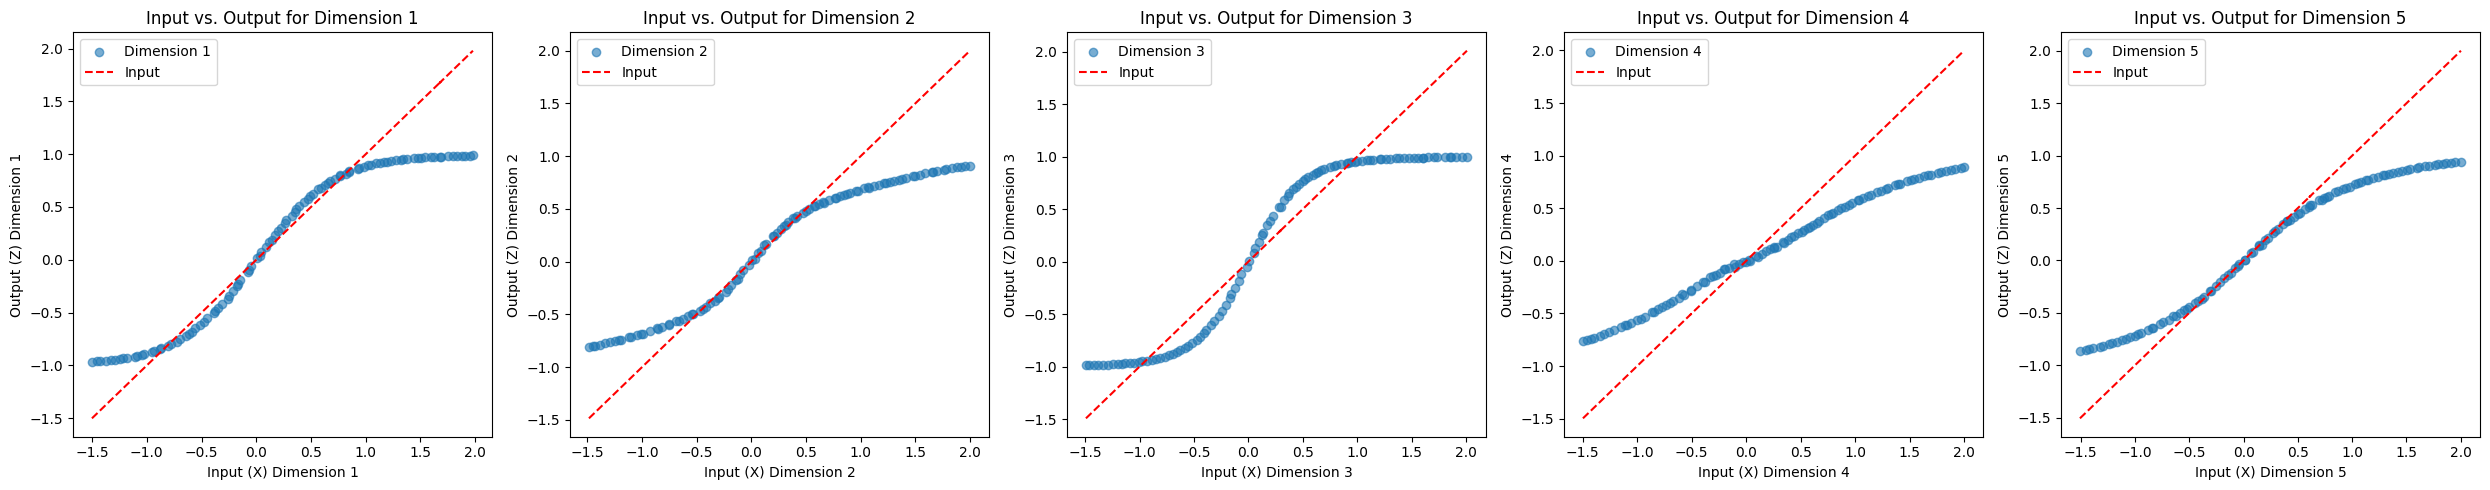

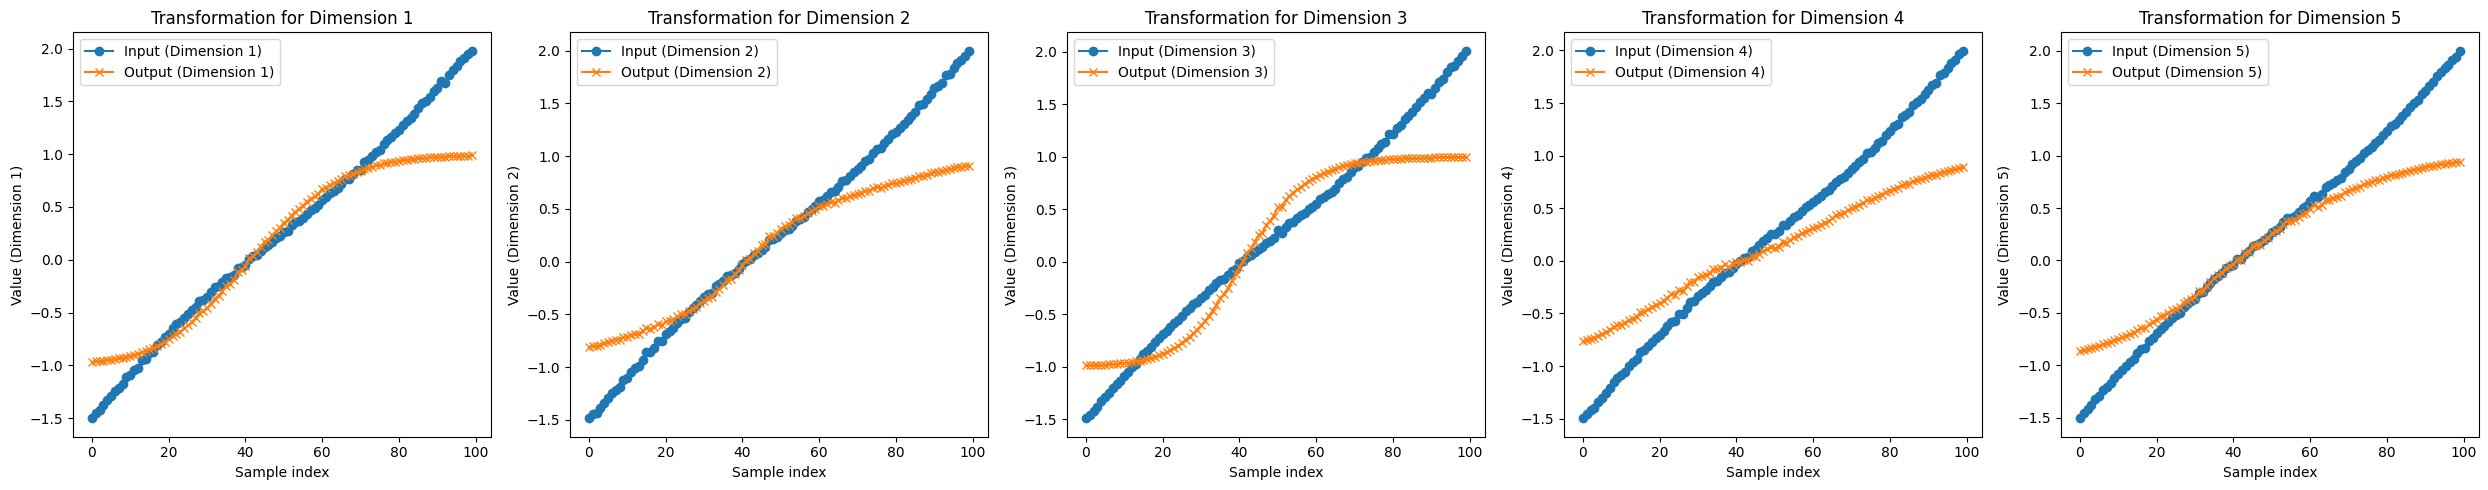

In [11]:
# Plot input vs. output for a few dimensions
plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.scatter(X[:, i].detach().numpy(), Z[:, i].detach().numpy(), label=f'Dimension {i+1}', alpha=0.6)
    plt.plot(X[:, i].detach().numpy(), X[:, i].detach().numpy(), 'r--', label='Input')
    plt.xlabel(f'Input (X) Dimension {i+1}')
    plt.ylabel(f'Output (Z) Dimension {i+1}')
    plt.title(f'Input vs. Output for Dimension {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

# Visualize the transformation of specific input features
plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(range(X.shape[0]), X[:, i].detach().numpy(), 'o-', label=f'Input (Dimension {i+1})')
    plt.plot(range(X.shape[0]), Z[:, i].detach().numpy(), 'x-', label=f'Output (Dimension {i+1})')
    plt.xlabel('Sample index')
    plt.ylabel(f'Value (Dimension {i+1})')
    plt.title(f'Transformation for Dimension {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# verify the correctness of the layer using the gradcheck command
layer1 = TanhNewtonImplicitLayer(5, tol=1e-10).double()
input = torch.randn(3, 5, requires_grad=True, dtype=torch.double)
gradcheck(layer1, input, check_undefined_grad=False)

True

# MNIST dataset

In [12]:
# import the MINST dataset and data loaders
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [13]:
# download the MNIST dataset from torchvision.datasets
mnist_train = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(".", train=False, download=True, transform=transforms.ToTensor())

# create a DataLoader
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4577972.77it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132599.45it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 240505.61it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8655396.99it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [14]:
# a generic function for running a single epoch (training or evaluation)
from tqdm.notebook import tqdm

def epoch(loader, model, opt=None, monitor=None):
  total_loss, total_err, total_monitor = 0., 0., 0.

  # initialize a loss function
  # criterian = nn.CrossEntropyLoss() # This is an object-oriented approach where you create an instance of the loss function and then call it with your predictions and targets.
  model.eval() if opt is None else model.train()

  # tqdm is a Python library that provides a fast, extensible progress bar for loops and other iterable processes
  # tqdm iterates over the data loader
  # train_loader has mnist_dataset_size = 60000 and batch_size = 100
  for X, y in tqdm(loader, leave=False):
    X, y = X.to(device), y.to(device) # move data and labels to the specified device

    # Extract the first element of the tuple if it's a tuple, otherwise use the output directly
    yp = model(X) # label prediction

    # calculate the loss
    # loss = criterian(yp, y)
    loss = nn.CrossEntropyLoss()(yp, y)

    # run model optimizer | SGD in this case
    if opt:
      for param in model.parameters():
        param.grad = None # set the gradients of the model parameters to zero
      loss.backward() # calculate the gradient in the backward pass

      # safety check: ensuring there are no NaN values in the gradients of any of the model parameters
      if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0: # execute optimization step only if no gradient has NaN
        opt.step() # applies - lr_rate * grad update on model parameters

    total_err += (yp.max(dim=1)[1] != y).sum().item() # Computes the number of misclassified samples in the batch
    total_loss += loss.item() * X.shape[0] # calculates the -ve loglikelihood estimate

    # The monitor parameter is an optional callable that allows you to track additional metrics beyond the loss and error
    # - The norm of the model parameters.
    # - Custom evaluation metrics such as precision, recall, F1 score, etc.
    # - Any other diagnostic information that can help understand the model's performance.
    if monitor is not None:
      total_monitor += monitor(model)

  return total_err /  len(loader.dataset), total_loss / len(loader.dataset), total_monitor / len(loader)

In [15]:
torch.manual_seed(0)
# Define the NN model + optimizer
model =nn.Sequential(nn.Flatten(),
                     nn.Linear(784, 100),
                     TanhNewtonImplicitLayer(100, max_iter=40),
                     nn.Linear(100, 10) # output is classification from 0, 9
                     ).to(device)

opt = torch.optim.SGD(model.parameters(), lr=1e-1)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.1114, Loss: 0.4030, Newton Iters: 40.00 | Test Error: 0.0698, Loss: 0.2377, Newton Iters: 40.00


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0584, Loss: 0.1975, Newton Iters: 40.00 | Test Error: 0.0607, Loss: 0.1994, Newton Iters: 40.00


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0443, Loss: 0.1488, Newton Iters: 40.00 | Test Error: 0.0466, Loss: 0.1493, Newton Iters: 40.00


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.0304, Loss: 0.1043, Newton Iters: 40.00 | Test Error: 0.0363, Loss: 0.1216, Newton Iters: 40.00


In [ ]:
# Train the model / Test/Eval the model
for i in range(4):
  if i == 3:
    opt.param_groups[0]["lr"] = 1e-2 # reduce the learning rate

  train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
  test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
  print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, Newton Iters: {train_fpiter:.2f} | " +
        f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, Newton Iters: {test_fpiter:.2f}")

In [35]:
# Confirm all tensors are on the same device
def check_device_consistency(model):
    """
    Checks if all tensors in the given neural network model are on the same device.

    Args:
        model (torch.nn.Module): The neural network model to check.

    Returns:
        bool: True if all tensors are on the same device, False otherwise.
        str: The device name if all tensors are on the same device, otherwise 'Mismatch'.
    """
    # Retrieve the device of the first parameter
    devices = set(param.device for param in model.parameters())

    # Add devices of buffers (e.g., running means, running vars in batchnorm layers)
    devices.update(buffer.device for buffer in model.buffers())

    # Check if all devices are the same
    if len(devices) == 1:
        return True, devices.pop()
    else:
        return False, 'Mismatch'

# Example usage:
model = model  # Replace with your model
# Check device consistency
is_consistent, device = check_device_consistency(model)
if is_consistent:
    print(f"All tensors are on the same device: {device}")
else:
    print("Tensors are on different devices")


All tensors are on the same device: cuda:0


# VISUALIZE PREDICTIONS

GroundTruth:      7     2     1     0     4     1     4     9
Predicted:      7     2     1     0     4     1     4     9
(3, 392, 242)


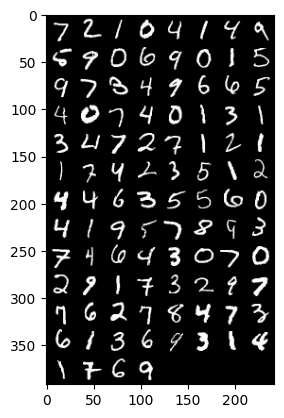

In [36]:
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='OrRd_r')
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Print the actual labels
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

# Make predictions
outputs = model(images)

# Get the predicted class with the highest score
_, predicted = torch.max(outputs, 1)

# Print the predicted labels
print('Predicted: ', ' '.join('%5s' % predicted[j].item() for j in range(8)))

# Show images
# Unnormalize the images and make a grid
images_grid = torchvision.utils.make_grid(images.cpu(), nrow=8, normalize=True)
imshow(images_grid)

# Visualize Computational Graph

In [31]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

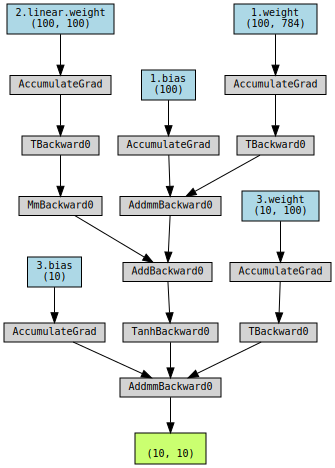

In [40]:
# Visualizing the computational graph of the network above
from torchviz import make_dot
import networkx as nx

input_tensor = torch.randn(10, 784)

# Move the input tensor to the same device as the model
if torch.cuda.is_available():
    input_tensor = input_tensor.to('cuda')

# Perform a forward pass to build the computational graph
output = model(input_tensor)

# Visualize the computational graph
graph = make_dot(output, params=dict(model.named_parameters()))

graph

# what we have achieved in chapter 1
1. solve a non-inear root-finding problem via newton's methods, equivalent to finding the fixed-point of an infinite-depth network, and
2. integrates easily into automatic differentiation tools